<a href="https://colab.research.google.com/github/trevinofernando/Algorithms-for-Machine-Learning/blob/master/CreditCardFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fraud Classifiers for Credit Card Transactions


In this notebook I will use different classifiers, data cleaning techniques, handcrafting features, dimensionality reduction, graphs for visualization and data exploration between other things. All with the intention to find a good classifier for the the credit card dataset given by my professor.

##Setup

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from enum import Enum 
import matplotlib.pyplot as plt
from google.colab import files,drive
from sklearn.model_selection import train_test_split


Globals and Enums

In [ ]:
#Enums:
class AXIS(Enum):
    row = 0
    col = 1

Progress bar GUI

In [ ]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

#Demostration of Progress Bar
out = display(progress(0, 100), display_id=True)
for i in range(101):
  out.update(progress(i, 100))

Mount google drive to load data

In [ ]:
#Mount to my google drive
drive.mount('/content/drive',force_remount=True)

os.chdir('/content/drive/My Drive/Colab Notebooks/Datasets/CreditCardFrauds')
!pwd

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Datasets/CreditCardFrauds


In [ ]:
!ls

original_transaction_df.csv  transactions.txt
saved_transaction_df.csv     transactions.zip


###Read dataset in json format into dataframe

In [ ]:
# converts list of dictionary of intances into dictionary of features 
# and returns column oriented dataframe 
def load_data(data):
    parse_data=data[0].keys()
    trans_data={}
    for i in parse_data:
        trans_data[i]=list()
    for row in data:
        for keys,values in row.items():
            if values=='':
                trans_data[keys].append(np.nan) #missing datapoints are assigned with 'NaN'
            else:
                trans_data[keys].append(values)
    return pd.DataFrame.from_dict(trans_data)

In [ ]:
#Opening the file
contents = open("transactions.txt", "r").read()  
list_dict = [json.loads(str(item)) for item in contents.strip().split('\n')]
original_transaction_df = load_data(list_dict)

#Transaction data Data Frame
original_transaction_df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,733493772,733493772,5000.0,5000.00,2016-01-08T19:04:50,111.33,Lyft,US,US,05,01,rideshare,04/2020,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False
1,733493772,733493772,5000.0,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,09,01,rideshare,06/2023,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,NaN,111.33,NaN,NaN,NaN,False,NaN,NaN,False
2,733493772,733493772,5000.0,4863.92,2016-01-11T13:36:55,187.40,Lyft,US,US,05,01,rideshare,12/2027,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,NaN,136.08,NaN,NaN,NaN,False,NaN,NaN,False
3,733493772,733493772,5000.0,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,02,01,rideshare,09/2029,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,NaN,323.48,NaN,NaN,NaN,False,NaN,NaN,False
4,733493772,733493772,5000.0,4449.18,2016-01-16T01:41:11,0.00,Lyft,US,US,02,01,rideshare,10/2024,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,False,NaN,550.82,NaN,NaN,NaN,False,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641909,186770399,186770399,7500.0,2574.02,2016-12-04T12:29:21,5.37,Apple iTunes,US,US,05,08,mobileapps,01/2030,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,4925.98,NaN,NaN,NaN,False,NaN,NaN,False
641910,186770399,186770399,7500.0,2568.65,2016-12-09T04:20:35,223.70,Blue Mountain eCards,US,US,09,01,online_gifts,05/2026,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,4931.35,NaN,NaN,NaN,False,NaN,NaN,False
641911,186770399,186770399,7500.0,2344.95,2016-12-16T07:58:23,138.42,Fresh Flowers,US,US,02,01,online_gifts,10/2019,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,5155.05,NaN,NaN,NaN,False,NaN,NaN,False
641912,186770399,186770399,7500.0,2206.53,2016-12-19T02:30:35,16.31,abc.com,US,US,09,08,online_subscriptions,11/2029,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,5293.47,NaN,NaN,NaN,False,NaN,NaN,False


##Exploring Dataset part 1

In [ ]:
out = display(progress(0, 5), display_id=True)
out.update(progress(0, 5))
summary_df = original_transaction_df.describe(include = 'all')
out.update(progress(1, 5))

summary_df.loc['dtype'] = original_transaction_df.dtypes
out.update(progress(2, 5))
summary_df.loc['mode'] = original_transaction_df.mode().iloc[0]
out.update(progress(3, 5))
summary_df.loc['median'] = original_transaction_df.median()
out.update(progress(4, 5))
summary_df.loc['NaN_%'] = original_transaction_df.isnull().mean()
out.update(progress(5, 5))

summary_df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
count,641914,641914,641914,641914,641914,641914,641914,638001,641290,638569,641627,641914,641914,641914,641914,641914,641914,641914,641325,641914,0,641914,0,0,0,641914,0,0,641914
unique,5000,5000,NaN,NaN,635472,NaN,2493,4,4,5,3,19,165,1826,2186,899,980,5134,3,2,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2
top,318001076,318001076,NaN,NaN,2016-06-15T22:46:39,NaN,Lyft,US,US,05,01,online_retail,05/2026,2015-12-11,2016-07-20,633,633,1789,PURCHASE,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False
freq,10034,10034,NaN,NaN,3,NaN,25311,632303,635577,255615,514144,161469,4209,10137,3948,11354,11254,10034,608685,630612,NaN,NaN,NaN,NaN,NaN,340453,NaN,NaN,640945
mean,NaN,NaN,10697.2,6652.83,NaN,135.162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4044.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,11460.4,9227.13,NaN,147.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5945.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,250,-1244.93,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,5000,1114.97,NaN,32.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,502.442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,7500,3578.16,NaN,85.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2151.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,15000,8169.18,NaN,189.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5005.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As seen above, the row 'NaN_%' shows the percent of missing values for each column and we can see that 6 columns are completly filled with NaN values (echoBuffer, merchantCity, etc.). And using the 'mode' to replace NaN values would make the most sense as long as it is used per account.

##Data Cleaning

###Dimensionality Reduction

####Handling columns missing a significant amount of data (80% or more)

In [ ]:
transaction_df = original_transaction_df.copy()
for col in transaction_df:
  if summary_df.loc['NaN_%',col] >= 0.80:
    print("Dropping column '{}' for having {}% of NaN entries".format( col , summary_df.loc['NaN_%',col] * 100.0))
    transaction_df.drop(col, axis=AXIS.col.value, inplace=True)

print("Old dimensions: {}".format(original_transaction_df.shape))
print("New dimensions: {}".format(transaction_df.shape))
transaction_df.head()


Dropping column 'echoBuffer' for having 100.0% of NaN entries
Dropping column 'merchantCity' for having 100.0% of NaN entries
Dropping column 'merchantState' for having 100.0% of NaN entries
Dropping column 'merchantZip' for having 100.0% of NaN entries
Dropping column 'posOnPremises' for having 100.0% of NaN entries
Dropping column 'recurringAuthInd' for having 100.0% of NaN entries
Old dimensions: (641914, 29)
New dimensions: (641914, 23)


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,733493772,733493772,5000.0,5000.00,2016-01-08T19:04:50,111.33,Lyft,US,US,05,01,rideshare,04/2020,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,0.00,False,False
1,733493772,733493772,5000.0,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,09,01,rideshare,06/2023,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,111.33,False,False
2,733493772,733493772,5000.0,4863.92,2016-01-11T13:36:55,187.40,Lyft,US,US,05,01,rideshare,12/2027,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,136.08,False,False
3,733493772,733493772,5000.0,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,02,01,rideshare,09/2029,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,323.48,False,False
4,733493772,733493772,5000.0,4449.18,2016-01-16T01:41:11,0.00,Lyft,US,US,02,01,rideshare,10/2024,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,False,550.82,False,False


####Remove duplicate columns

In [ ]:
#Code snipets taken from: https://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
#https://stackoverflow.com/questions/10710328/comparing-numpy-arrays-containing-nan

def nan_equal(a,b):
  try:
    np.testing.assert_equal(a,b)
  except AssertionError:
    return False
  return True

def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cols = frame[v].columns
        vs = frame[v]
        numCols = len(cols)

        for i in range(numCols):
            ia = vs.iloc[:,i].values
            for j in range(i+1, numCols):
                ja = vs.iloc[:,j].values
                if nan_equal(ia, ja):
                    print("Marking column '{}' as duplicate of column '{}'". format(cols[i], cols[j]))
                    dups.append(cols[i])
                    break

    return dups

In [ ]:
print("Old dimensions: {}".format(transaction_df.shape))
dupl_cols = duplicate_columns(transaction_df)
print("Columns to be removed for being duplicates: {} ".format(dupl_cols))
transaction_df = transaction_df.drop(dupl_cols, axis=AXIS.col.value)
print("New dimensions: {}".format(transaction_df.shape))
transaction_df.head()

Old dimensions: (641914, 23)
Marking column 'accountNumber' as duplicate of column 'customerId'
Columns to be removed for being duplicates: ['accountNumber'] 
New dimensions: (641914, 22)


,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,733493772,5000.0,5000.00,2016-01-08T19:04:50,111.33,Lyft,US,US,05,01,rideshare,04/2020,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,0.00,False,False
1,733493772,5000.0,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,09,01,rideshare,06/2023,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,111.33,False,False
2,733493772,5000.0,4863.92,2016-01-11T13:36:55,187.40,Lyft,US,US,05,01,rideshare,12/2027,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,136.08,False,False
3,733493772,5000.0,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,02,01,rideshare,09/2029,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,323.48,False,False
4,733493772,5000.0,4449.18,2016-01-16T01:41:11,0.00,Lyft,US,US,02,01,rideshare,10/2024,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,False,550.82,False,False


####Removing unnecessary columns that won't help fraud detection



In [ ]:
#Taking a better look at the data
for col in transaction_df.columns: 
    print("Column name: {}".format(col))
    print("{} unique values".format(transaction_df[col].unique().size))
    print("Column Type: {}".format(transaction_df[col].dtypes))
    print("{}\n".format(transaction_df[col].unique()))

#Removing unnecessary columns
bad_col = ['currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardLast4Digits', 'transactionDateTime']
transaction_df = transaction_df.drop(bad_col, axis=AXIS.col.value)

Column name: customerId
5000 unique values
Column Type: object
['733493772' '578754168' '664577296' ... '995944847' '808328364'
 '186770399']

Column name: creditLimit
10 unique values
Column Type: float64
[ 5000.  7500.   250. 20000.   500. 50000.  2500. 15000.  1000. 10000.]

Column name: availableMoney
450690 unique values
Column Type: float64
[5000.   4888.67 4863.92 ... 2566.12 2574.02 2568.65]

Column name: transactionDateTime
635472 unique values
Column Type: object
['2016-01-08T19:04:50' '2016-01-09T22:32:39' '2016-01-11T13:36:55' ...
 '2016-12-16T07:58:23' '2016-12-19T02:30:35' '2016-12-28T11:14:14']

Column name: transactionAmount
62735 unique values
Column Type: float64
[111.33  24.75 187.4  ... 695.87 607.64 883.79]

Column name: merchantName
2493 unique values
Column Type: object
['Lyft' 'Uber' 'Fresh eCards' ... 'Runners #332755' 'Curves #440052'
 'Virgin #218063']

Column name: acqCountry
5 unique values
Column Type: object
['US' nan 'PR' 'MEX' 'CAN']

Column name: merch

###Replace NaN values with mode

In [ ]:
#Replace NaN values with mode TODO: refactor code to do it by customerId

for col in transaction_df:
  if summary_df.loc['NaN_%',col] > 0.0:
    print("Replacing NaN entries on column'{}' with mode: {}".format(col, summary_df.loc['mode',col]))
    transaction_df[col].fillna(summary_df.loc['mode',col], inplace=True)

Replacing NaN entries on column'acqCountry' with mode: US
Replacing NaN entries on column'merchantCountryCode' with mode: US
Replacing NaN entries on column'posEntryMode' with mode: 05
Replacing NaN entries on column'posConditionCode' with mode: 01
Replacing NaN entries on column'transactionType' with mode: PURCHASE


###Adding handcrafted feature

In [ ]:
#Adding handcrafted feature
def usedCorrectCVV (row):
   return row['cardCVV'] == row['enteredCVV']

transaction_df['usedCorrectCVV']= transaction_df.apply (lambda row: usedCorrectCVV(row), axis=1)
print(transaction_df['usedCorrectCVV'].value_counts())

#Removing unnecessary columns
bad_col = ['cardCVV', 'enteredCVV']
transaction_df = transaction_df.drop(bad_col, axis=AXIS.col.value)

True     635977
False      5937
Name: usedCorrectCVV, dtype: int64


###Encoding of labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

columnsToEncode = ['customerId', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'transactionType']

#dictionary of encoders for decoding later
dict_encoders = {}
encoded_coloumns = []
boolean_coloumns = ['isFraud', 'cardPresent', 'expirationDateKeyInMatch', 'usedCorrectCVV']

for col in columnsToEncode:
  # LabelEncoder
  encoder = LabelEncoder()
  transaction_df[col] = encoder.fit_transform(transaction_df[col])
  dict_encoders[col] = encoder
  encoded_coloumns.append(col)

transaction_df = transaction_df.astype({'isFraud':                  'int',
                                        'cardPresent':              'int',
                                        'expirationDateKeyInMatch': 'int',
                                        'usedCorrectCVV':           'int'
                                       })

Note that by casting the 'isFraud ' column to int, we will achieve an equivalent outcome of using One Hot encoding since this is a binary choice

In [ ]:
#Decoding test
dict_encoders['posEntryMode'].inverse_transform(transaction_df['posEntryMode'])

array(['05', '09', '05', ..., '02', '09', '09'], dtype=object)

In [ ]:
def Decode(key, code):
    if key in encoded_coloumns:
      return dict_encoders[key].inverse_transform(transaction_df[key])[np.where(transaction_df[key].to_numpy() == code)[0][0]]
    elif key in boolean_coloumns:
      return code == 1
    else:
      return code
print("For 'posEntryMode': ")
print(" - '0' is the encoded value of {}".format(Decode('posEntryMode', 0)))
print(" - '1' is the encoded value of {}".format(Decode('posEntryMode', 1)))
print(" - '2' is the encoded value of {}".format(Decode('posEntryMode', 2)))

For 'posEntryMode': 
 - '0' is the encoded value of 02
 - '1' is the encoded value of 05
 - '2' is the encoded value of 09


##Gathering Data for visualization

###Taking a look at the data on each column

In [ ]:
for col in transaction_df.columns: 
    print("Column name: {}".format(col))
    print("{} unique values".format(transaction_df[col].unique().size))
    print("Column Type: {}".format(transaction_df[col].dtypes))
    print("{}\n".format(transaction_df[col].unique()))

Column name: customerId
5000 unique values
Column Type: int64
[3506 2643 3107 ... 4981 3922  440]

Column name: creditLimit
10 unique values
Column Type: float64
[ 5000.  7500.   250. 20000.   500. 50000.  2500. 15000.  1000. 10000.]

Column name: availableMoney
450690 unique values
Column Type: float64
[5000.   4888.67 4863.92 ... 2566.12 2574.02 2568.65]

Column name: transactionAmount
62735 unique values
Column Type: float64
[111.33  24.75 187.4  ... 695.87 607.64 883.79]

Column name: merchantName
2493 unique values
Column Type: int64
[1066 2086  607 ... 1688  329 2141]

Column name: acqCountry
4 unique values
Column Type: int64
[3 2 1 0]

Column name: merchantCountryCode
4 unique values
Column Type: int64
[3 2 1 0]

Column name: posEntryMode
5 unique values
Column Type: int64
[1 2 0 4 3]

Column name: posConditionCode
3 unique values
Column Type: int64
[0 1 2]

Column name: merchantCategoryCode
19 unique values
Column Type: int64
[17 13 16  4  3 15 12  7  5 14  0 11  6  2 18  1  9

###Fraud frequencies per category on each column compared relatively per category

In [ ]:
bb = [1,2,3,4,5,6]
dd = [1,2,3,4,5,6]
np.divide(bb,dd)

array([1., 1., 1., 1., 1., 1.])

creditLimit
--->5000.0


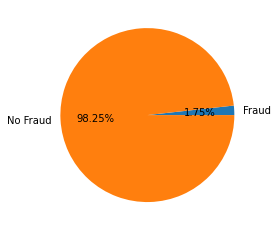

--->7500.0


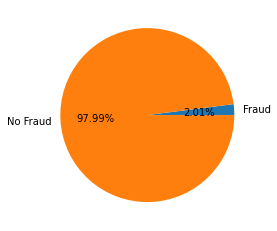

--->250.0


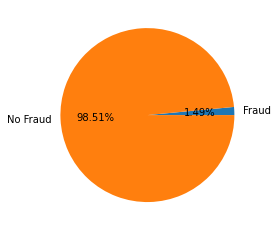

--->20000.0


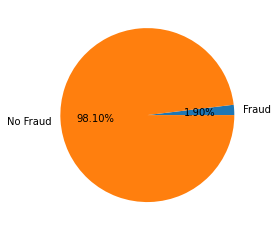

--->500.0


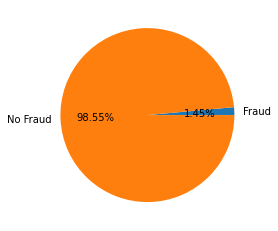

--->50000.0


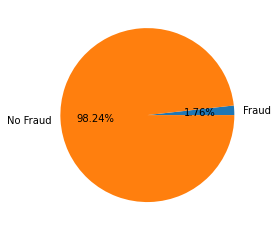

--->2500.0


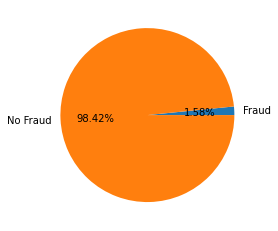

--->15000.0


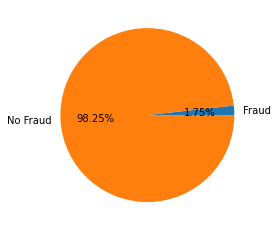

--->1000.0


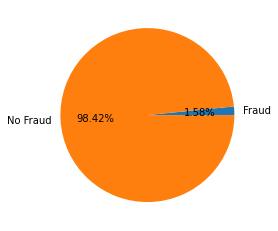

--->10000.0


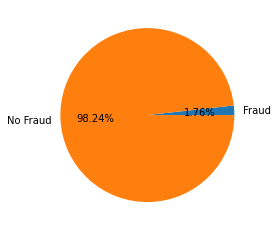

All 'creditLimit' codes side by side


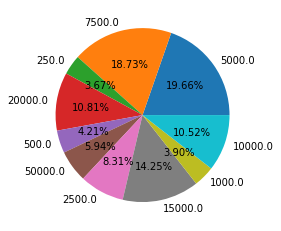

acqCountry
--->US


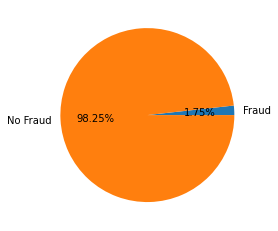

--->PR


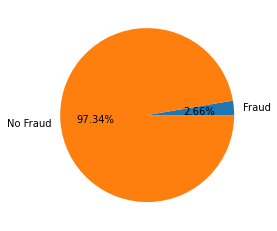

--->MEX


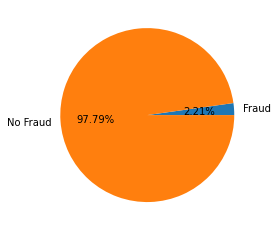

--->CAN


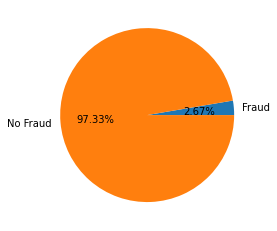

All 'acqCountry' codes side by side


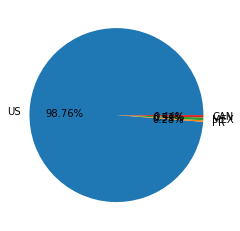

merchantCountryCode
--->US


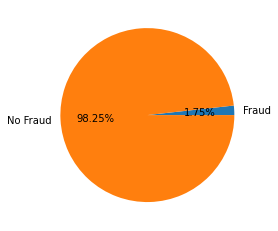

--->PR


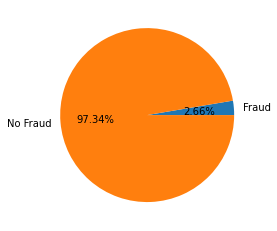

--->MEX


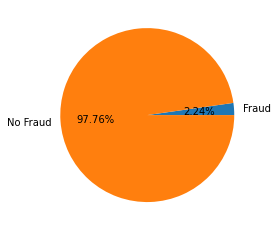

--->CAN


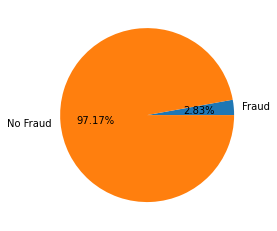

All 'merchantCountryCode' codes side by side


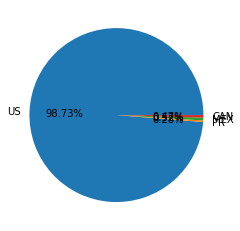

posEntryMode
--->05


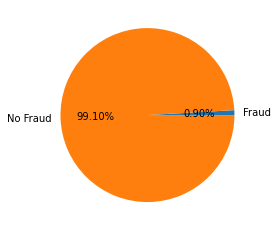

--->09


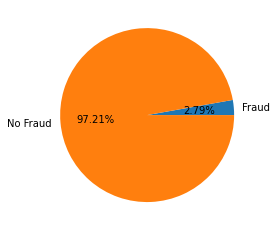

--->02


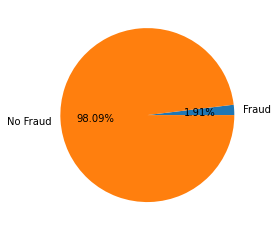

--->90


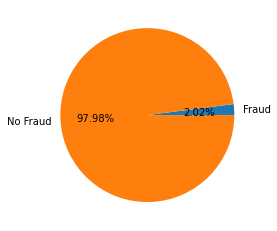

--->80


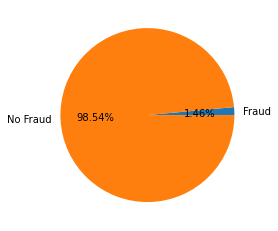

All 'posEntryMode' codes side by side


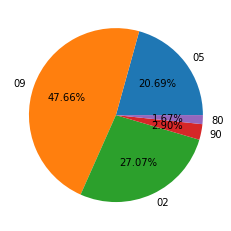

posConditionCode
--->01


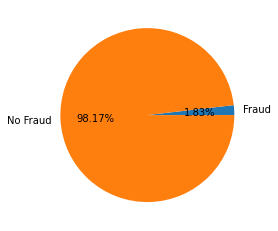

--->08


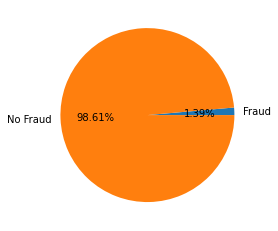

--->99


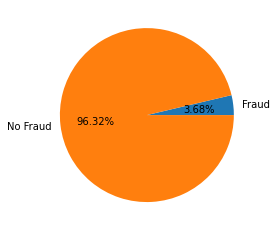

All 'posConditionCode' codes side by side


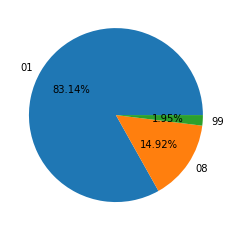

merchantCategoryCode
--->rideshare


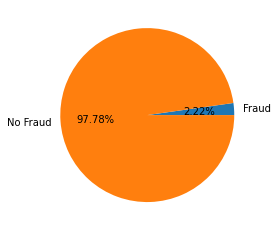

--->online_gifts


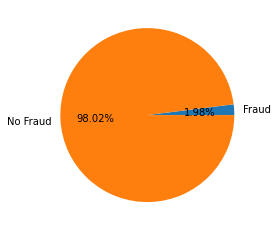

--->personal care


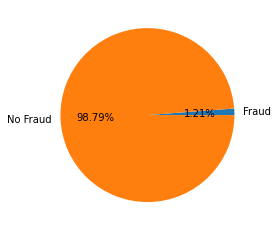

--->fastfood


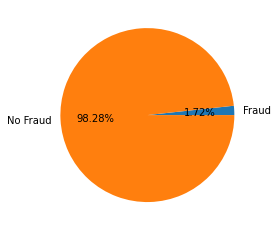

--->entertainment


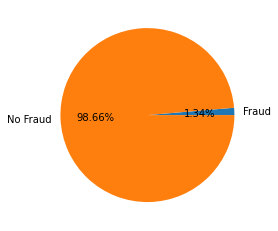

--->online_subscriptions


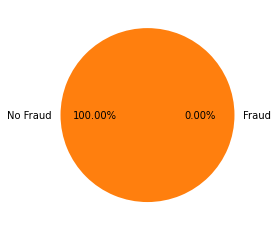

--->mobileapps


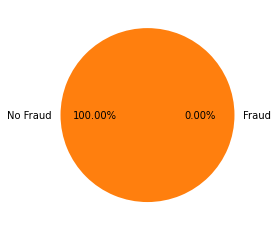

--->fuel


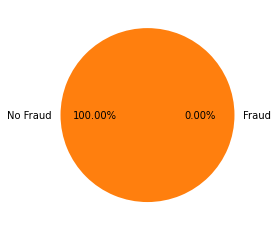

--->food


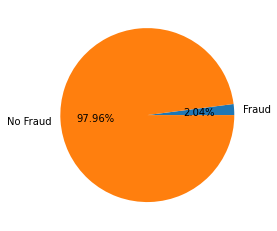

--->online_retail


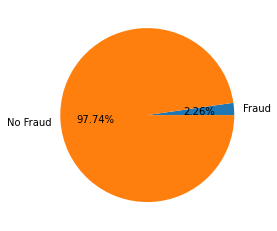

--->airline


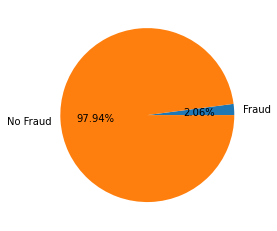

--->hotels


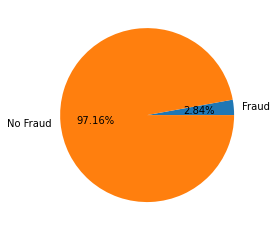

--->food_delivery


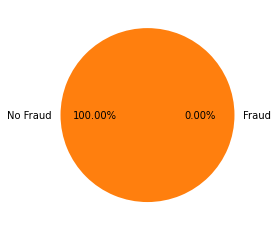

--->cable/phone


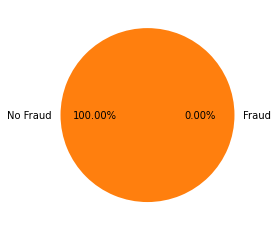

--->subscriptions


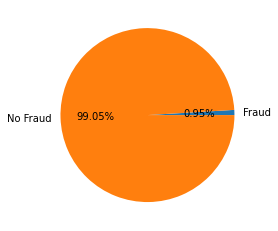

--->auto


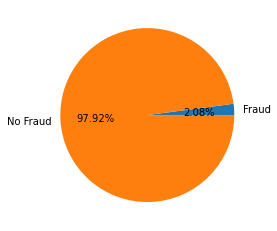

--->gym


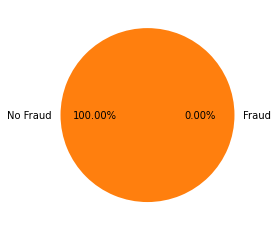

--->furniture


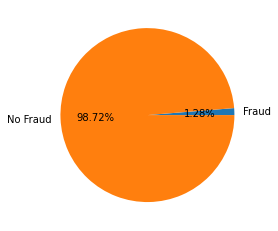

--->health


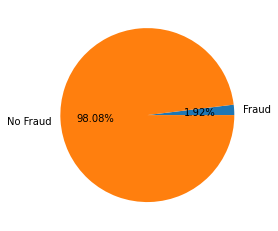

All 'merchantCategoryCode' codes side by side


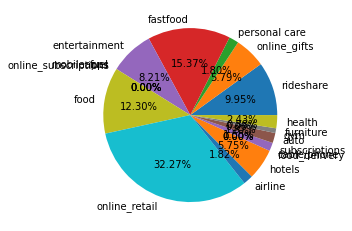

transactionType
--->PURCHASE


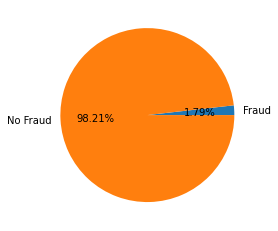

--->ADDRESS_VERIFICATION


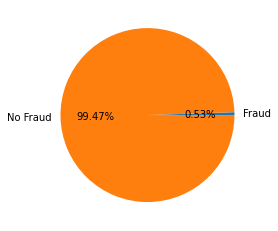

--->REVERSAL


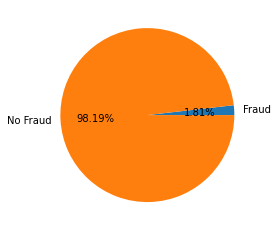

All 'transactionType' codes side by side


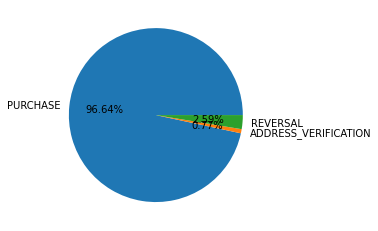

cardPresent
--->False


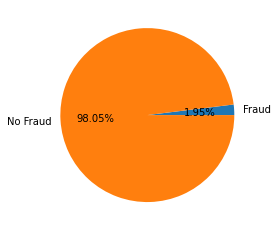

--->True


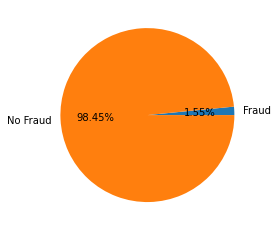

All 'cardPresent' codes side by side


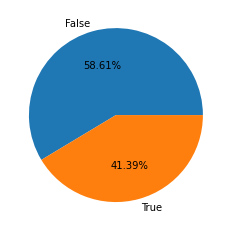

expirationDateKeyInMatch
--->False


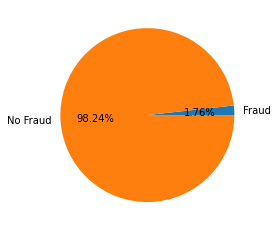

--->True


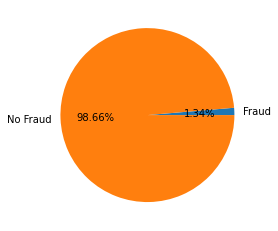

All 'expirationDateKeyInMatch' codes side by side


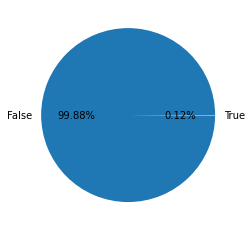

usedCorrectCVV
--->True


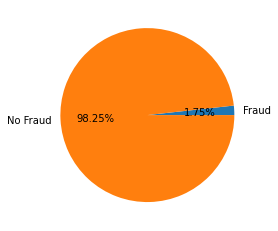

--->False


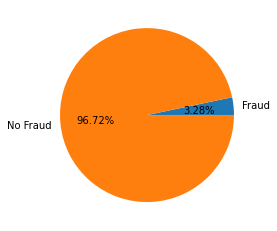

All 'usedCorrectCVV' codes side by side


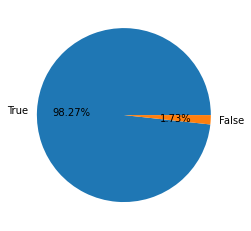

In [ ]:
#Container for all columns
codes = []
fraud_frequencies = []
fraud_percentages = []
cols_used = []

for col in transaction_df.columns: 
  if (col == 'isFraud'):
    continue

  #Containers for each column
  codes_by_column = []
  fraud_frequencies_by_column = []
  fraud_percentages_by_column = []

  if (transaction_df[col].unique().size < 20):
    print(col)
    cols_used.append(col)

    for code in transaction_df[col].unique():
      #Decoding code to see what it meant
      print("--->" + str(Decode(col, code)))
      codes_by_column.append( str(Decode(col, code)))

      #Gather data 
      fraud_count = transaction_df[(transaction_df[col]==code) & (transaction_df['isFraud']==1)].count()[0]
      noFraud_count = transaction_df[(transaction_df[col]==code) & (transaction_df['isFraud']==0)].count()[0]

      fraud_frequencies_by_column.append(fraud_count)
      fraud_percentages_by_column.append( fraud_count / (fraud_count + noFraud_count) )

      plt.pie([fraud_count, noFraud_count], labels = ['Fraud', 'No Fraud'] ,autopct='%1.2f%%')
      plt.show() 
    #END For

    #Populate container for all columns
    codes.append(codes_by_column)
    fraud_frequencies.append(fraud_frequencies_by_column)
    fraud_percentages.append(fraud_percentages_by_column)

    print("All '" + col + "' codes side by side")
    plt.pie(fraud_frequencies_by_column, labels = codes_by_column,autopct='%1.2f%%')
    plt.show() 
  #END If

#END For

###Fraud frequencies per category on each column compared relatively per column



Fraud Frequncies for 'creditLimit'


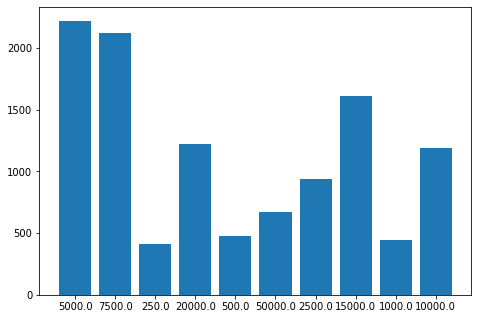

Fraud Percentages for 'creditLimit'


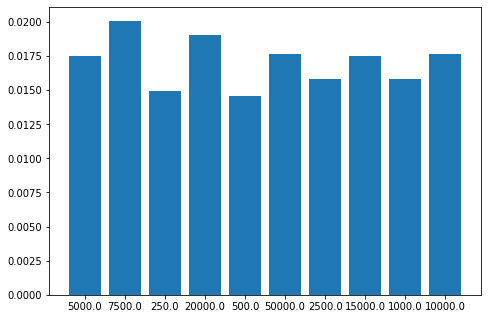

Fraud Frequncies for 'acqCountry'


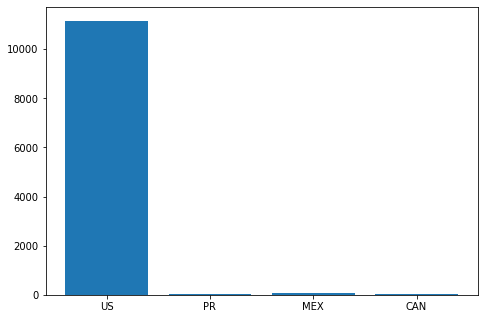

Fraud Percentages for 'acqCountry'


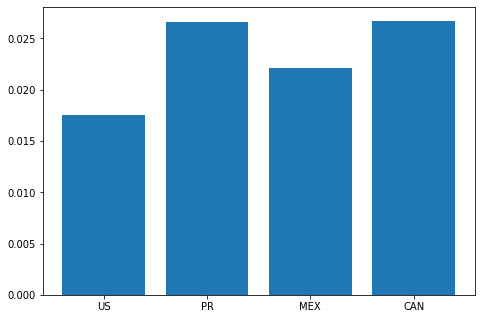

Fraud Frequncies for 'merchantCountryCode'


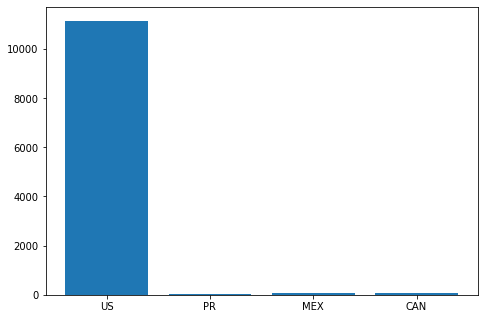

Fraud Percentages for 'merchantCountryCode'


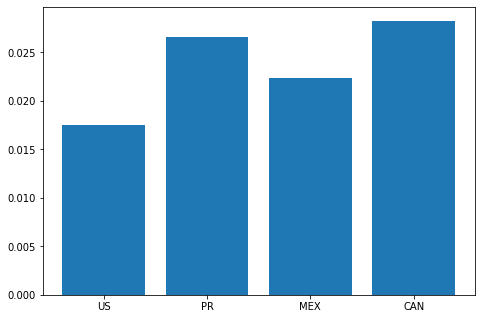

Fraud Frequncies for 'posEntryMode'


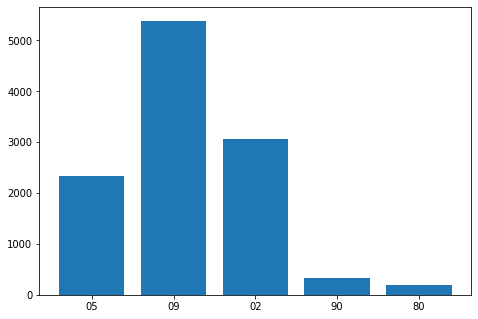

Fraud Percentages for 'posEntryMode'


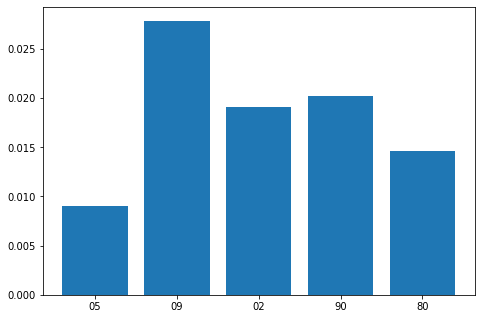

Fraud Frequncies for 'posConditionCode'


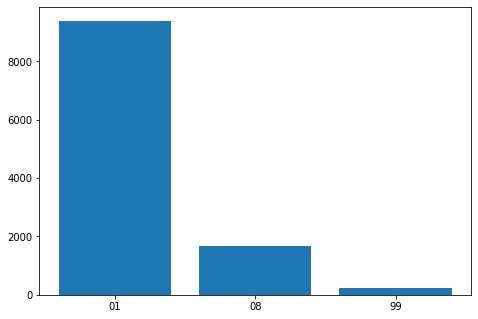

Fraud Percentages for 'posConditionCode'


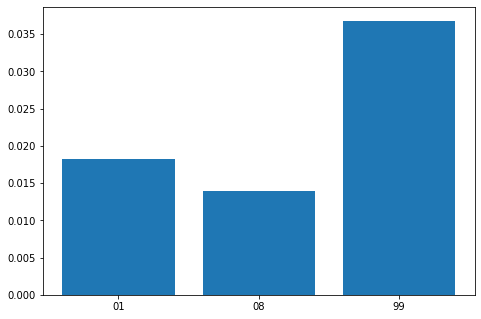

Fraud Frequncies for 'merchantCategoryCode'


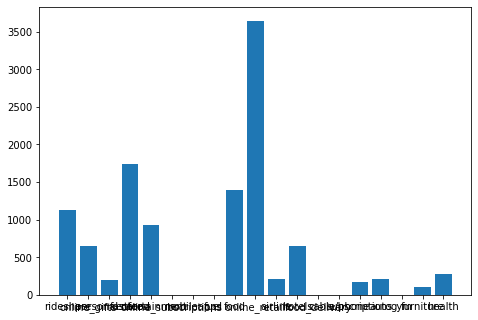

['rideshare', 'online_gifts', 'personal care', 'fastfood', 'entertainment', 'online_subscriptions', 'mobileapps', 'fuel', 'food', 'online_retail', 'airline', 'hotels', 'food_delivery', 'cable/phone', 'subscriptions', 'auto', 'gym', 'furniture', 'health']
Fraud Percentages for 'merchantCategoryCode'


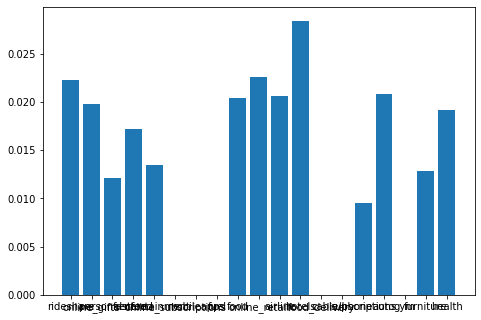

Fraud Frequncies for 'transactionType'


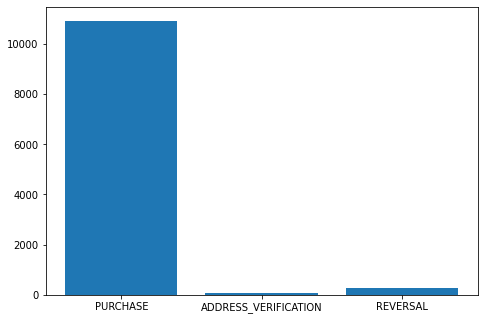

Fraud Percentages for 'transactionType'


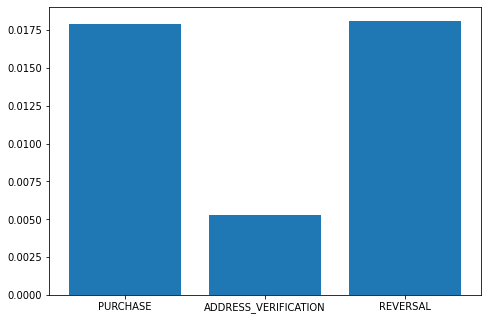

Fraud Frequncies for 'cardPresent'


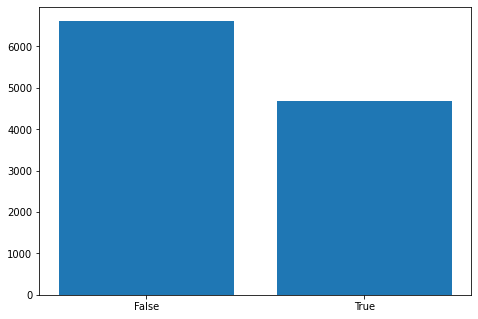

Fraud Percentages for 'cardPresent'


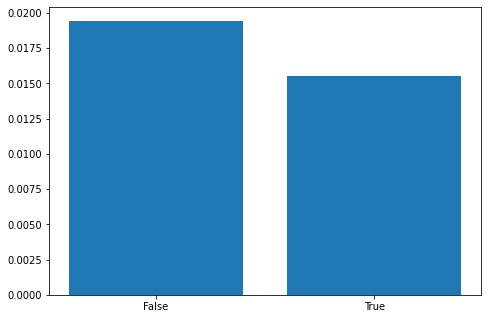

Fraud Frequncies for 'expirationDateKeyInMatch'


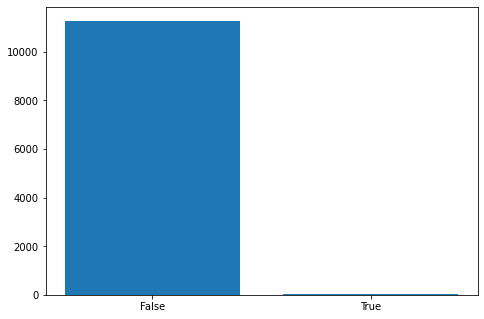

Fraud Percentages for 'expirationDateKeyInMatch'


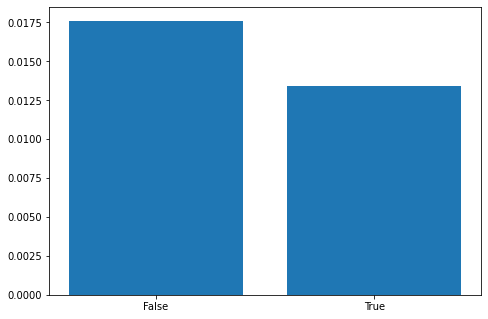

Fraud Frequncies for 'usedCorrectCVV'


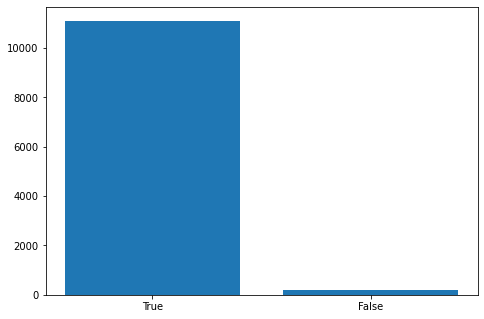

Fraud Percentages for 'usedCorrectCVV'


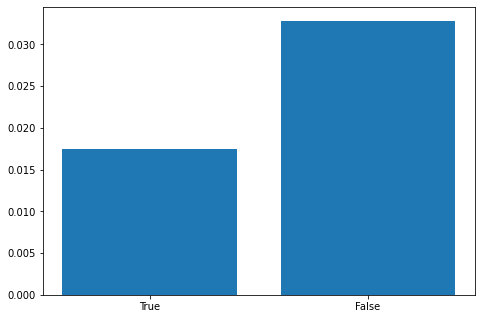

In [ ]:
for i in range(len(codes)):
  print("Fraud Frequncies for '" + cols_used[i] + "'")
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(codes[i],fraud_frequencies[i])
  plt.show()
  if(cols_used[i] == 'merchantCategoryCode'):
    print(codes[i])
  print("Fraud Percentages for '" + cols_used[i] + "'")
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(codes[i],fraud_percentages[i])
  plt.show()

###Fraud percentages per category on each column compared relatively per column

creditLimit


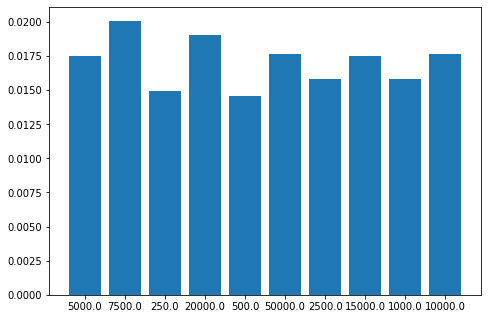

acqCountry


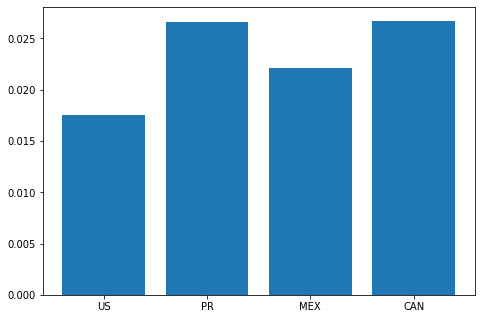

merchantCountryCode


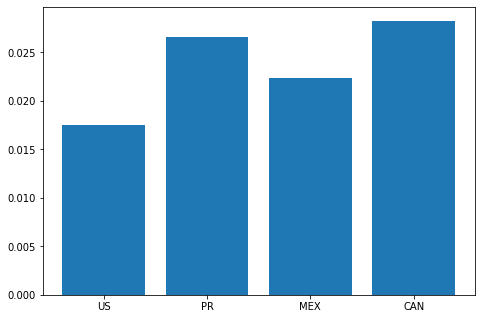

posEntryMode


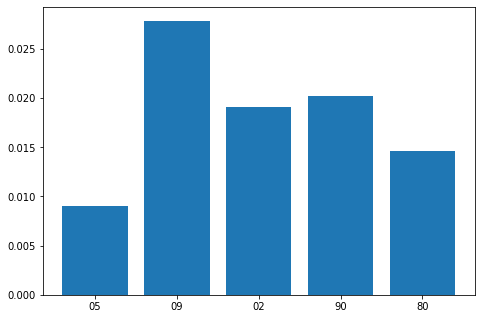

posConditionCode


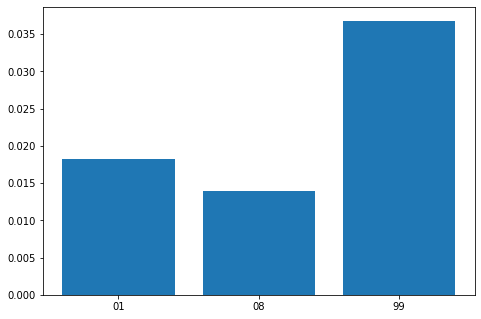

merchantCategoryCode


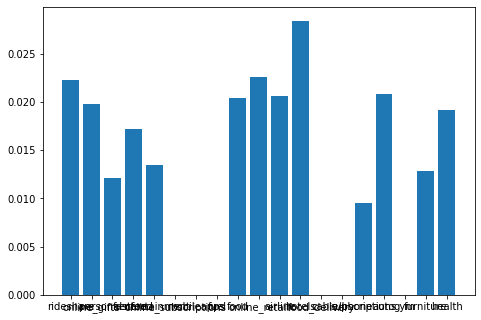

transactionType


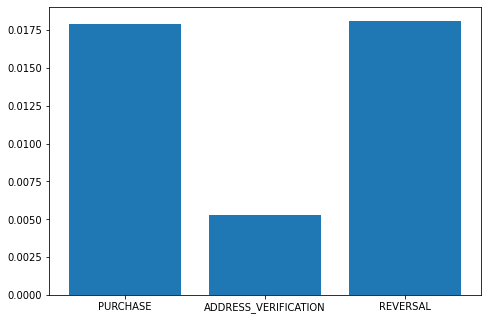

cardPresent


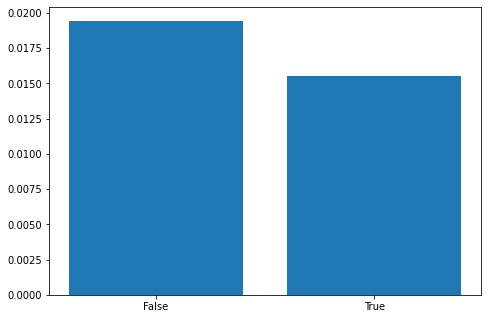

expirationDateKeyInMatch


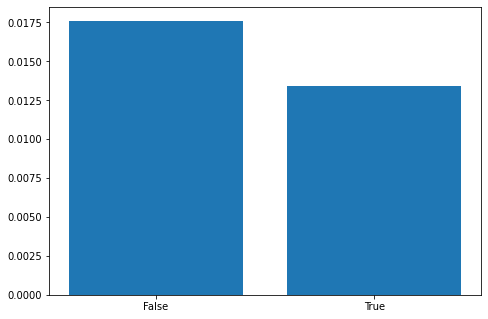

usedCorrectCVV


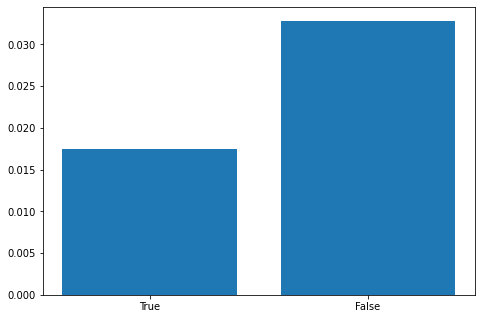

In [ ]:
for i in range(len(codes)):
  print(cols_used[i])
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(codes[i],fraud_percentages[i])
  plt.show()

###Handling entries with a missing label

In [ ]:
#Definetly don't want to guess labels. So drop any entry with missing labels (column=isFraud)
numRows = transaction_df.shape[AXIS.row.value]
transaction_df.dropna(subset = ['isFraud'])
print("Number of rows with missing labels: {}".format(numRows - transaction_df.shape[AXIS.row.value]))
if(numRows - transaction_df.shape[0] == 0):
  print("* This dataset had no missing labels. No entries were removed.")
numRows = transaction_df.shape[AXIS.row.value]

Number of rows with missing labels: 0
* This dataset had no missing labels. No entries were removed.


##Make copy on drive to save progress

In [ ]:
#save  progress
os.chdir('/content/drive/My Drive/Colab Notebooks/Datasets/CreditCardFrauds')
transaction_df.to_csv('saved_transaction_df.csv', index=False)

###Read copy on drive from latest save

In [ ]:
transaction_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/CreditCardFrauds/saved_transaction_df.csv')
transaction_df

,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,usedCorrectCVV
0,3506,5000.0,5000.00,111.33,1066,3,3,1,0,17,1,1,0.00,0,0,1
1,3506,5000.0,4888.67,24.75,2086,3,3,2,0,17,1,0,111.33,0,0,1
2,3506,5000.0,4863.92,187.40,1066,3,3,1,0,17,1,0,136.08,0,0,1
3,3506,5000.0,4676.52,227.34,1066,3,3,0,0,17,1,1,323.48,0,0,1
4,3506,5000.0,4449.18,0.00,1066,3,3,0,0,17,0,0,550.82,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641909,440,7500.0,2574.02,5.37,43,3,3,1,1,12,1,0,4925.98,0,0,1
641910,440,7500.0,2568.65,223.70,161,3,3,2,0,13,1,0,4931.35,0,0,1
641911,440,7500.0,2344.95,138.42,605,3,3,0,0,13,1,0,5155.05,0,0,1
641912,440,7500.0,2206.53,16.31,2472,3,3,2,1,15,1,0,5293.47,0,0,1


##Machine Learning Models

###Neural Network

####Unbalanced dataset test

In [ ]:
from sklearn.model_selection import train_test_split
balanceDataset = False

frauds_df = transaction_df.loc[transaction_df['isFraud'] == 1]
nofrauds_df = transaction_df.loc[transaction_df['isFraud'] == 0]
nofrauds_df = nofrauds_df.sample(frauds_df.shape[0])

if balanceDataset:
  df = frauds_df.append(nofrauds_df, ignore_index=True)
else: #Not balancing dataset
  df = transaction_df

y = df['isFraud'].to_numpy()
X = df.drop('isFraud', axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(frauds_df.shape)
print(nofrauds_df.shape)
print(df.shape)
print(X.shape)
print(y.shape)

(11302, 16)
(11302, 16)
(641914, 16)
(641914, 15)
(641914,)


In [ ]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(30, input_dim=X.shape[AXIS.col.value], activation=keras.activations.sigmoid),
    keras.layers.Dense(10, activation=keras.activations.sigmoid),
    keras.layers.Dense(1, activation=keras.activations.sigmoid)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model
epochs = 5
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,y_train, batch_size=50, epochs=epochs, validation_split=0.33)

Epoch 1/5
6882/6882 [==============================] - 20s 3ms/step - loss: 0.0895 - accuracy: 0.9826 - val_loss: 0.0891 - val_accuracy: 0.9823
Epoch 2/5
6882/6882 [==============================] - 20s 3ms/step - loss: 0.0878 - accuracy: 0.9826 - val_loss: 0.0894 - val_accuracy: 0.9823
Epoch 3/5
6882/6882 [==============================] - 20s 3ms/step - loss: 0.0878 - accuracy: 0.9826 - val_loss: 0.0891 - val_accuracy: 0.9823
Epoch 4/5
6882/6882 [==============================] - 20s 3ms/step - loss: 0.0878 - accuracy: 0.9826 - val_loss: 0.0892 - val_accuracy: 0.9823
Epoch 5/5
6882/6882 [==============================] - 20s 3ms/step - loss: 0.0878 - accuracy: 0.9826 - val_loss: 0.0891 - val_accuracy: 0.9823


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (test_acc*100))

4012/4012 [==============================] - 7s 2ms/step - loss: 0.0901 - accuracy: 0.9820
Accuracy: 98.20


In [ ]:
test_loss, test_acc = model.evaluate(frauds_df.drop('isFraud', axis=1).to_numpy(), frauds_df['isFraud'].to_numpy())
print('Accuracy: %.2f' % (test_acc*100))

354/354 [==============================] - 1s 2ms/step - loss: 3.9980 - accuracy: 0.0000e+00
Accuracy: 0.00


####Balancing dataset with undersampling

In [ ]:
balanceDataset = True

frauds_df = transaction_df.loc[transaction_df['isFraud'] == 1]
nofrauds_df = transaction_df.loc[transaction_df['isFraud'] == 0]
nofrauds_df = nofrauds_df.sample(frauds_df.shape[0])

if balanceDataset:
  df = frauds_df.append(nofrauds_df, ignore_index=True)
else: #Not balancing dataset
  df = transaction_df

y = df['isFraud'].to_numpy()
X = df.drop('isFraud', axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

model = keras.Sequential([
    keras.layers.Dense(30, input_dim=X.shape[AXIS.col.value], activation=keras.activations.sigmoid),
    keras.layers.Dense(10, activation=keras.activations.sigmoid),
    keras.layers.Dense(1, activation=keras.activations.sigmoid)
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,y_train, batch_size=50, epochs=epochs, validation_split=0.33)
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (test_acc*100))
test_loss, test_acc = model.evaluate(frauds_df.drop('isFraud', axis=1).to_numpy(), frauds_df['isFraud'].to_numpy())
print('Accuracy with only frauds: %.2f' % (test_acc*100))

Epoch 1/5
243/243 [==============================] - 1s 3ms/step - loss: 0.6953 - accuracy: 0.5077 - val_loss: 0.6932 - val_accuracy: 0.5152
Epoch 2/5
243/243 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6922 - val_accuracy: 0.5132
Epoch 3/5
243/243 [==============================] - 1s 3ms/step - loss: 0.6928 - accuracy: 0.5075 - val_loss: 0.6919 - val_accuracy: 0.5221
Epoch 4/5
243/243 [==============================] - 1s 3ms/step - loss: 0.6926 - accuracy: 0.5074 - val_loss: 0.6915 - val_accuracy: 0.5250
Epoch 5/5
142/142 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.5154
Accuracy: 51.54
354/354 [==============================] - 1s 2ms/step - loss: 0.7001 - accuracy: 0.4156
Accuracy with only frauds: 41.56


###Stacking Classifier
Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

####Unbalanced dataset test

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# define the base models
level0 = list()
level0.append(('LR', LogisticRegression(verbose=True))) #2sec
#level0.append(('KNN', KNeighborsClassifier()))
#level0.append(('CART', DecisionTreeClassifier()))
#level0.append(('SVM', SVC(verbose=True)))
#level0.append(('Bayes', GaussianNB()))
level0.append(('BAG', BaggingClassifier(verbose=True))) #50sec
level0.append(('RF', RandomForestClassifier(verbose=True))) 
level0.append(('ET', ExtraTreesClassifier(verbose=True)))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, verbose=True)
# fit the model on all available data
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_j

StackingClassifier(cv=5,
                   estimators=[('LR',
                                LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=True,
                                                   warm_start=False)),
                               ('BAG',
                                BaggingClassifier(base_estimator=None,
                              

In [ ]:
# make a prediction for one example
predictions = model.predict(X_test)
(numLabels,) = y_test.shape
#Compare predicted labels against real labels and extract the bad predictions
wrong_indices = [i for i in range(numLabels) if predictions[i] != y_test[i]]
# The quantity below is equal to the test accuracy reported by the network fit method.
print(1.0 - len(wrong_indices) / numLabels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6044725547775016


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


In [ ]:
# make a prediction for one example
X_frauds = frauds_df.drop('isFraud', axis=1).to_numpy()
y_frauds = frauds_df['isFraud'].to_numpy()
predictions = model.predict(X_frauds)
(numLabels,) = y_frauds.shape
#Compare predicted labels against real labels and extract the bad predictions
wrong_indices = [i for i in range(numLabels) if predictions[i] != y_frauds[i]]
# The quantity below is equal to the test accuracy reported by the network fit method.
print(1.0 - len(wrong_indices) / numLabels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.5127411077685365


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


####Balancing dataset with undersampling

In [ ]:
balanceDataset = True

frauds_df = transaction_df.loc[transaction_df['isFraud'] == 1]
nofrauds_df = transaction_df.loc[transaction_df['isFraud'] == 0]
nofrauds_df = nofrauds_df.sample(frauds_df.shape[0])

if balanceDataset:
  df = frauds_df.append(nofrauds_df, ignore_index=True)
else: #Not balancing dataset
  df = transaction_df

y = df['isFraud'].to_numpy()
X = df.drop('isFraud', axis=1).to_numpy()
X = preprocessing.scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# define the base models
level0 = list()
level0.append(('LR', LogisticRegression(verbose=True))) #2sec
#level0.append(('KNN', KNeighborsClassifier()))
#level0.append(('CART', DecisionTreeClassifier()))
#level0.append(('SVM', SVC(verbose=True)))
#level0.append(('Bayes', GaussianNB()))
level0.append(('BAG', BaggingClassifier(verbose=True))) #50sec
level0.append(('RF', RandomForestClassifier(verbose=True))) 
level0.append(('ET', ExtraTreesClassifier(verbose=True)))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, verbose=True)
# fit the model on all available data
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_j

StackingClassifier(cv=5,
                   estimators=[('LR',
                                LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=True,
                                                   warm_start=False)),
                               ('BAG',
                                BaggingClassifier(base_estimator=None,
                              

In [ ]:
# make a prediction for one example
predictions = model.predict(X_test)
(numLabels,) = y_test.shape
#Compare predicted labels against real labels and extract the bad predictions
wrong_indices = [i for i in range(numLabels) if predictions[i] != y_test[i]]
# The quantity below is equal to the test accuracy reported by the network fit method.
print(1.0 - len(wrong_indices) / numLabels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7155496571554966


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
# make a prediction for one example
X_frauds = frauds_df.drop('isFraud', axis=1).to_numpy()
y_frauds = frauds_df['isFraud'].to_numpy()
predictions = model.predict(X_frauds)
(numLabels,) = y_frauds.shape
#Compare predicted labels against real labels and extract the bad predictions
wrong_indices = [i for i in range(numLabels) if predictions[i] != y_frauds[i]]
# The quantity below is equal to the test accuracy reported by the network fit method.
print(1.0 - len(wrong_indices) / numLabels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


0.7459741638648028


By looking at the results of the Neural Network: Using a Neural Network with an unbalanced dataset and using regular accuarcy as metric yield terrible results with an accuarcy of 0 on the "only frauds" dataset. But in the other hand, undersampling to balance the dataset improved the network to correctly classify 40% of all frauds.

And by looking at the results of the other combined classifiers: We can see that even with an unbalanced dataset, and using F1 scores, the stacked classfiers were able achieve 51% accuarcy on the "only frauds" dataset. While with a balanced dataset they were able to achieve 74%

### Accuarcies on entire dataset:

.................................|Balanced|Unbalanced|

Neural Network.......|51%........|98%..............|

Stacked Classifiers.|71%........|60%..............|

*Note:* The 98% accuarcy on the NN is the worst for our purposes, because it achieved a 0% accuarcy on the "only frauds" dataset below. 

### Accuarcies on "only frauds" dataset:

.................................|Balanced|Unbalanced|

Neural Network.......|41%........|0.0%.............|

Stacked Classifiers.|74%........|51%..............|

So at the end of the day, the Stacked Classifiers are the clear winners and while the it achieved a greater score with a balanced dataset, it still hold itself with an unbalanced dataset with significantly more data and thus probably with a more generalized classification.

In [ ]:
#https://machinelearningmastery.com/imbalanced-classification-with-the-fraudulent-credit-card-transactions-dataset/
#https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/
#https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
#https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
#https://scikit-learn.org/stable/modules/preprocessing.html
#https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc